In [1]:
import os
import threading
import time

import matplotlib.pyplot as plt

import numpy as np
import scipy as sp
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

import torch
from torch.optim import Adam

from kfp import construct_B, diffusion_coeff, construct_R, construct_P, gauss_seidel, solve_pde, logsumexp, construct_A, get_sparse_A_block
from network import ScoreNet

from data.Dataset import CIFARDataset

torch.manual_seed(2);

mm_scaler = MinMaxScaler();

%load_ext line_profiler

## Parameters

In [2]:
### Change these
N = 10
H = 28
W = 28
epochs = 3
eps = 1e-6
sigma = 25
###

eps = 1e-6
dt = 1/N

## Instantiate Dataset

In [3]:
dataset = CIFARDataset(W, H);

channels = dataset.channels
n_data = len(dataset)

Files already downloaded and verified


## Create Model

In [4]:
model_score = ScoreNet(H=H, W=W, in_channels=channels)
loss_fn = torch.nn.MSELoss()
optimizer = Adam(model_score.parameters(), lr=1e-3)

model_score.train();

## Create memory buffers

In [5]:
scores = np.zeros((N, channels, H, W), dtype=np.float32)
kdes = np.full((n_data, channels), None)

params = {"bandwidth": np.logspace(-1, 1, 20)}
P = construct_P(int(W), int(H/2))
P_block = sp.linalg.block_diag(*([P] * (N-1)))
sparse_P_block = sp.sparse.block_diag(([P] * (N-1)))

R = construct_R(P)
R_block = sp.linalg.block_diag(*([R] * (N-1)))
sparse_R_block = sp.sparse.block_diag(([R] * (N-1)))

## Diffuse Function for 1 channel

In [6]:
def get_init_score(data, data_idx, channel):
  if kdes[data_idx, channel] is None:
      grid = GridSearchCV(KernelDensity(), params)
      kdes[data_idx, channel] = grid.fit(data.ravel()[:, None]).score_samples(data.ravel()[:, None])
  return kdes[data_idx, channel]

def get_A_block(dx, dy, random_t, time_, sigma_, scores, channel):
  # we normalize for sigma to ensure the dynamics doesn't blow up
  As = []
  for i, t_ in enumerate(random_t, 1):
    A = construct_A(dx, dy, t_ - time_[i-1], np.sqrt(2) * sigma_[i], scores[i][channel].ravel(), H, W)
    As.append(A)

  A_block = sp.linalg.block_diag(*As)
  for i, t_ in enumerate(random_t, 1):
    if i == 1:
      continue
    A_block[(i-1)*H*W:i*H*W, (i-2)*H*W:(i-1)*H*W] = -np.eye((H*W))/(t_ - time_[i-1])
  
  return A_block

def get_B_block(dx, dy, time_, m, sigma_, channel):
  B_block = np.array([])
  for i in range(N-1):
    B_block = np.append(B_block, construct_B(dx, dy, time_[i+1] - time_[i], m[channel][i].ravel(), np.zeros((H, W)), sigma_[i+1], scores[i][channel].ravel(), i))
  
  return B_block
  
def construct_samples(random_t, del_m, m, m_c, sigma_, train_x_data, train_y_data, train_xc_data, channel):
  # constructing the training data and labels
  for i, t_ in enumerate(random_t, 1):
    del_m[channel][i] = np.diff(m[channel][i].ravel(), axis=0, prepend=m[channel][i, 0])

  x = torch.tensor(mm_scaler.fit_transform(np.exp((-m[channel].ravel() - logsumexp(-m[channel].ravel())))[:, None])).reshape((N, 1, H, W))
  perturbed_x = x + torch.randn_like(x) * torch.sqrt(2 * torch.tensor(sigma_)**2)[:, None, None, None]
  train_x_data[:, channel] = perturbed_x[:, 0]
  train_y_data[:, channel] = torch.tensor(del_m[channel].astype(np.float32)).reshape((N, H, W))

  # generate coarse dataset
  x_c = torch.tensor(mm_scaler.fit_transform(np.exp((-m_c[channel].ravel() - logsumexp(-m_c[channel].ravel())))[:, None])).reshape((N, int(H/2), int(W/2)))
  perturbed_xc = x_c + torch.randn_like(x_c) * torch.sqrt(2 * torch.tensor(sigma_)**2)[:, None, None]
  train_xc_data[:, channel] = perturbed_xc

In [7]:
def diffuse(data, x, m , del_m, m_c, channel, train_xc_data, train_x_data, train_y_data, random_t, time_, sigma_, data_idx):
    data = data[channel]
    dx = data.detach().numpy().max()/H
    dy = data.detach().numpy().max()/W
    
    x[channel][0] = torch.tensor(mm_scaler.fit_transform(data.ravel()[:, None]).astype(np.float32).reshape((1, 1, H, W)))
    m[channel][0] = get_init_score(data, data_idx, channel)
    del_m[channel][0] = np.diff(m[channel][0].ravel(), axis=0, prepend=m[channel][0,0])
    
    A_block = get_sparse_A_block(dx, dy, random_t - time_[:N-1], np.sqrt(2) * sigma_[1:], scores[1:, channel], H, W, N)
    
    B_block = get_B_block(dx, dy, time_, m, sigma_, channel)
    
    # update m (pre-smoothing)
    m[channel][1:] = gauss_seidel(A_block, B_block, scores[1:, channel].flatten(), A_block.shape[0]).reshape(((N-1), H*W)
    
    # we want to perform the coarse grid
    # compute residual r = b - Am[1:]
    r = B_block - A_block@(m[channel][1:]).flatten()
    # coursening step 1: r_c = R_c@r
    r_c = R_block@r
    # coursening A_c = R_c@A@P_c (Petrov-Galerkin Coursening)
    
    A_c = (sparse_R_block@A_block@sparse_P_block)
    
    # compute course err: err_c = solve_pde(A_c,r_c)
    err_c = solve_pde(A_c, r_c, mode='sp_sparse')
    
    # interpolate to fine grid: err = P_c@err_c
    err = P_block@err_c
    # we apply fine grid-correction
    m[channel][1:] = (m[channel][1:].flatten() + err).reshape((N-1, H*W))
    # post smoothing
    m[channel][1:] = gauss_seidel(A_block, B_block, m[channel][1:].flatten(), A_block.shape[0]).reshape(((N-1), H*W))
    # we want to coarsen the score function to train on coarse data
    m_c[channel][1:] = (R_block@m[channel][1:].flatten()).reshape((-1, int(H*W/4)))
    
    construct_samples(random_t, del_m, m, m_c, sigma_, train_x_data, train_y_data, train_xc_data, channel)
    

## Profile

In [8]:

x = torch.zeros((channels, N, H, W))
m = np.zeros((channels, N, H*W), dtype=np.float32)
del_m = np.zeros_like(m, dtype=np.float32)
m_c = np.zeros((channels, N, int((H*W/4))), dtype=np.float32)
# we want to sample from random time steps to construct training samples
random_t = np.linspace([dt + eps] * n_data, [1] * n_data, N-1, axis=1).astype(np.float64)
random_t += np.random.uniform(-dt/2, dt/2, random_t.shape)
random_t[:, -1] = 1
time_ = np.sort(np.insert(random_t, 0, eps, axis=1), axis=1).astype(np.float32)
sigma_ = diffusion_coeff(torch.tensor(time_), sigma).detach().cpu().numpy()

data = dataset.__getitem__(0)
train_xc_data = torch.zeros((N, channels, int(H/2), int(W/2)))
train_x_data = torch.zeros((N, channels, H, W))
train_y_data = torch.zeros_like(train_x_data)

#%lprun -u 0.1 -f construct_A_test construct_A_test(0.01, 0.01, random_t[0] - time_[0][:N-1],  np.zeros((N-1, H, W)), sigma_[0][1:], scores[1:, 0], H, W)
%lprun -u 0.1 -f diffuse diffuse(data, x, m, del_m, m_c, 0, train_xc_data, train_x_data, train_y_data, random_t[0], time_[0], sigma_[0], 0)

Timer unit: 0.1 s

Total time: 0.611008 s
File: /tmp/ipykernel_2520023/1571479245.py
Function: diffuse at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def diffuse(data, x, m , del_m, m_c, channel, train_xc_data, train_x_data, train_y_data, random_t, time_, sigma_, data_idx):
     2         1          0.0      0.0      0.0      data = data[channel]
     3         1          0.0      0.0      0.0      dx = data.detach().numpy().max()/H
     4         1          0.0      0.0      0.0      dy = data.detach().numpy().max()/W
     5                                               
     6         1          0.0      0.0      0.2      x[channel][0] = torch.tensor(mm_scaler.fit_transform(data.ravel()[:, None]).astype(np.float32).reshape((1, 1, H, W)))
     7         1          3.5      3.5     56.7      m[channel][0] = get_init_score(data, data_idx, channel)
     8         1          0.0      0.0      0.0      del_m[channe

## Train

  0%|          | 0/3 [00:00<?, ?it/s]

time:  1.161818504333496


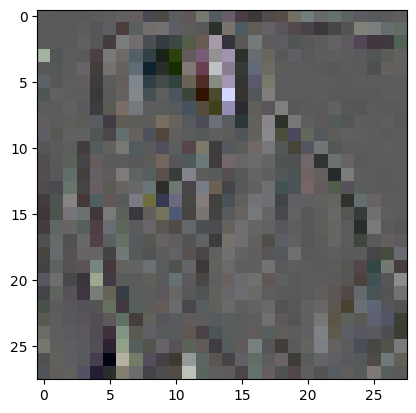

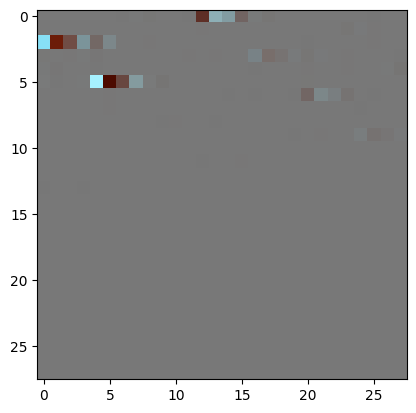

inf
inf


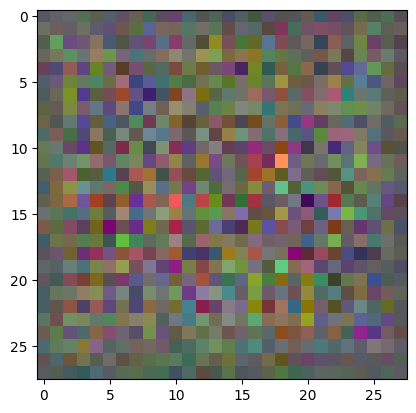

 33%|███▎      | 1/3 [00:01<00:03,  1.65s/it]

time:  0.4464256763458252


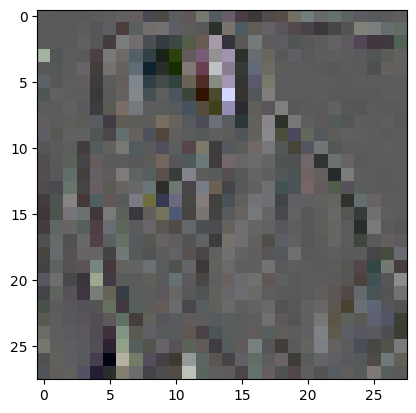

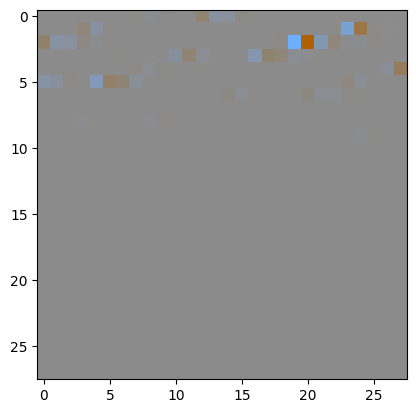

inf
inf


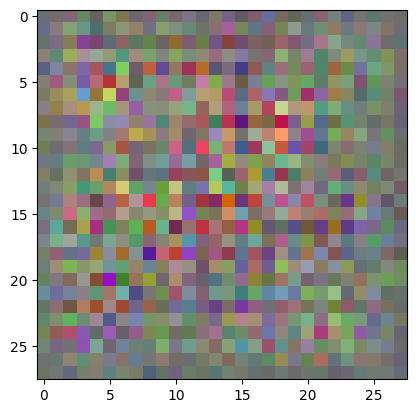

 67%|██████▋   | 2/3 [00:02<00:01,  1.19s/it]

time:  0.4432086944580078


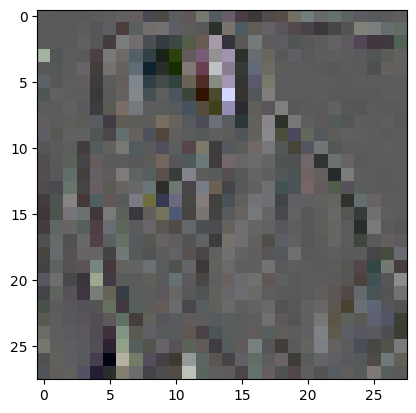

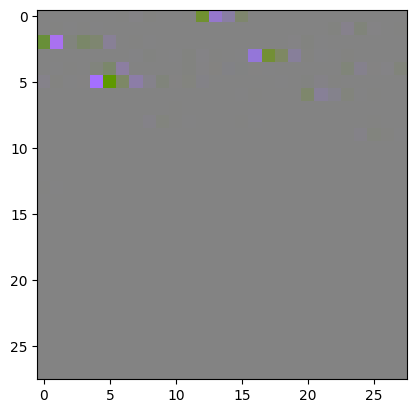

inf
inf


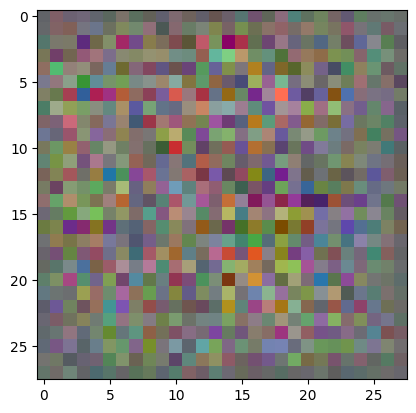

100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


model has been saved


In [9]:

threads = [None] * channels
loss_c_hist = []
loss_hist = []

for e in tqdm(range(epochs)):
  x = torch.zeros((channels, N, H, W))
  m = np.zeros((channels, N, H*W), dtype=np.float32)
  del_m = np.zeros_like(m, dtype=np.float32)
  m_c = np.zeros((channels, N, int((H*W/4))), dtype=np.float32)
  # we want to sample from random time steps to construct training samples
  random_t = np.linspace([dt + eps] * n_data, [1] * n_data, N-1, axis=1)
  random_t += np.random.uniform(-dt/2, dt/2, random_t.shape)
  random_t[:, -1] = 1
  time_ = np.sort(np.insert(random_t, 0, eps, axis=1), axis=1).astype(np.float32)
  sigma_ = diffusion_coeff(torch.tensor(time_), sigma).detach().cpu().numpy()
  for idx, x_ in enumerate(dataset):
    data = x_
    train_xc_data = torch.zeros((N, channels, int(H/2), int(W/2)))
    train_x_data = torch.zeros((N, channels, H, W))
    train_y_data = torch.zeros_like(train_x_data)
    
    # diffuse all three channels concurrently
    start = time.time()
    for i in range(channels):
      threads[i] = threading.Thread(target=diffuse, args=[data, x, m, del_m, m_c, i, train_xc_data, train_x_data, train_y_data, random_t[idx], time_[idx], sigma_[idx], idx])
      threads[i].start()
    for thread in threads:
      thread.join()
      
    print("time: ", time.time() - start)
    
    # plt.imshow(train_x_data[-1].moveaxis(0, 2))
    # plt.show()
    plt.imshow(np.clip((train_y_data[0] + abs(torch.min(train_y_data[0]))) / (torch.max(train_y_data[0]) + abs(torch.min(train_y_data[0]))), 0, 1).reshape((channels, H, W)).moveaxis(0, 2))
    plt.show()
    plt.imshow(np.clip((train_y_data[-1] + abs(torch.min(train_y_data[-1]))) / (torch.max(train_y_data[-1]) + abs(torch.min(train_y_data[-1]))), 0, 1).reshape((channels, H, W)).moveaxis(0, 2))
    plt.show()
    yc_pred = model_score(train_xc_data, torch.tensor(time_[idx]), coarse=True)
    lm = (2*torch.tensor(sigma_[idx])**2)[:, None, None, None]
    loss = loss_fn(yc_pred/lm, train_y_data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses = loss.item()
    loss_c_hist.append(losses)
    print(losses)

    y_pred = model_score(train_x_data, torch.tensor(time_[idx]))
    lm = (2*torch.tensor(sigma_[idx])**2)[:, None, None, None]
    loss = loss_fn(y_pred/lm, train_y_data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses = loss.item()
    loss_hist.append(losses)
    print(losses)
    scores = (y_pred/lm).clone().detach().cpu().numpy().reshape((N, channels, H, W)) # we normalize before fedding back into PDE
    # scores[1] = (y_pred/lm).clone().detach().cpu().numpy().reshape((N, H, W))
    # scores[2] = (y_pred/lm).clone().detach().cpu().numpy().reshape((N, H, W))
    plt.imshow(np.moveaxis(np.clip((scores[0] + abs(np.min(scores[0]))) / (np.max(scores[0]) + abs(np.min(scores[0]))), 0, 1).reshape((channels, H, W)), 0, 2))
    plt.show()

torch.save(model_score.state_dict(), 'model_cifar.pth')
print(f"\nmodel has been saved")